In [352]:
import matplotlib.pyplot as plt
import numpy as num

from pyrocko import util, model, io, trace, moment_tensor, gmtpy
from pyrocko import pz
from pyrocko import orthodrome as od
from pyrocko.io import quakeml
from pyrocko.io import stationxml as fdsn
from pyrocko.client import catalog
from pyrocko.automap import Map

from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime
from obspy.core.event import Catalog
from obspy.core.stream import Stream
from obspy.core.event import Event
from obspy.core.event import Origin
from obspy.core.event import Magnitude
from obspy import read
from obspy import read_events
from obspy import read_inventory
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import pickle

import geopy.distance


workdir='../'

plotdir =  os.path.join(workdir,'PLOTS')
plotdir =  os.path.join(plotdir,'AMP_DIST')

catdir =  os.path.join(workdir,'CAT')
meta_datadir=os.path.join(workdir,'META_DATA')
datadir=os.path.join(workdir,'DATA_response')

In [353]:
#select stations (pyrocko)
station_name = os.path.join(meta_datadir, 'stations_flegrei_INGV.pf')

st = model.load_stations(station_name)
print('Number of stations', len(st))

Number of stations 49


In [354]:
#select catalogue (pyrocko)
catname = os.path.join(catdir, 'catologue_flegrei_new_mag2_5.pf')

events = model.load_events(catname)
print('Number of events:', len(events))

Number of events: 50


In [355]:
#select event
##############################################################################
name='flegrei_2022_12_28_02_35_57'     ########################################CHANGE
##############################################################################

ev_dir=os.path.join(datadir,name)
ev_name=os.path.join(ev_dir,name + '.mseed')

for ev in events:
    if ev.name==name:
        print('selected event:',ev.name)
        print('lat:',ev.lat,' lon:',ev.lon)
        event=ev

selected event: flegrei_2022_12_28_02_35_57
lat: 40.819  lon: 14.145


In [356]:
#select wavelet (obspy)  
w=read(ev_name)
w[0].__dict__

{'stats':          network: IV
         station: CAAM
        location: 
         channel: HHE
       starttime: 2022-12-28T02:35:37.520000Z
         endtime: 2022-12-28T02:36:37.520000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 6001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 106, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 4070400}),
 'data': array([-4.96587632e-05, -4.98045886e-05, -4.99416540e-05, ...,
        -2.12397043e-05, -2.10372980e-05, -2.08348560e-05])}

In [357]:
st_coord=[]
for trace in w:
    for s in st:
        if trace.stats.station==s.station:
            st_coord.append( [trace.stats.station, trace.stats.channel , s.lat,s.lon,max(trace.data) ] )
    
print(len(st_coord))

75


In [358]:
#calculate distance
coords_event = (event.lat, event.lon)

dist_vs_amp=[]

for row in st_coord:
    coords_station = (row[2], row[3])
    dist= geopy.distance.distance(coords_event, coords_station).km

    dist_vs_amp.append( [row[0], row[1],dist,row[4]] )
dist_vs_amp[0]

['CAAM', 'HHE', 0.27562296615131965, 0.00023672608132442992]

In [359]:
# separate 3 channels
channel1=[]
channel2=[]
channel3=[]
distance1=[]
distance2=[]
distance3=[]
hhe=[]
hhn=[]
hhz=[]

for row in dist_vs_amp:
    channel=row[1]
    if channel=='HHE':
        hhe.append(row[3])
        distance1.append(row[2])
        channel1.append(row[0])
    elif channel=='HHN':
        hhn.append(row[3])
        distance2.append(row[2])
        channel2.append(row[0])
    elif channel=='HHZ':
        hhz.append(row[3])
        distance3.append(row[2])
        channel3.append(row[0])

print(len(distance1),len(hhe),len(channel1))
print(len(distance2),len(hhn),len(channel2))
print(len(distance3),len(hhz),len(channel3))

25 25 25
25 25 25
25 25 25


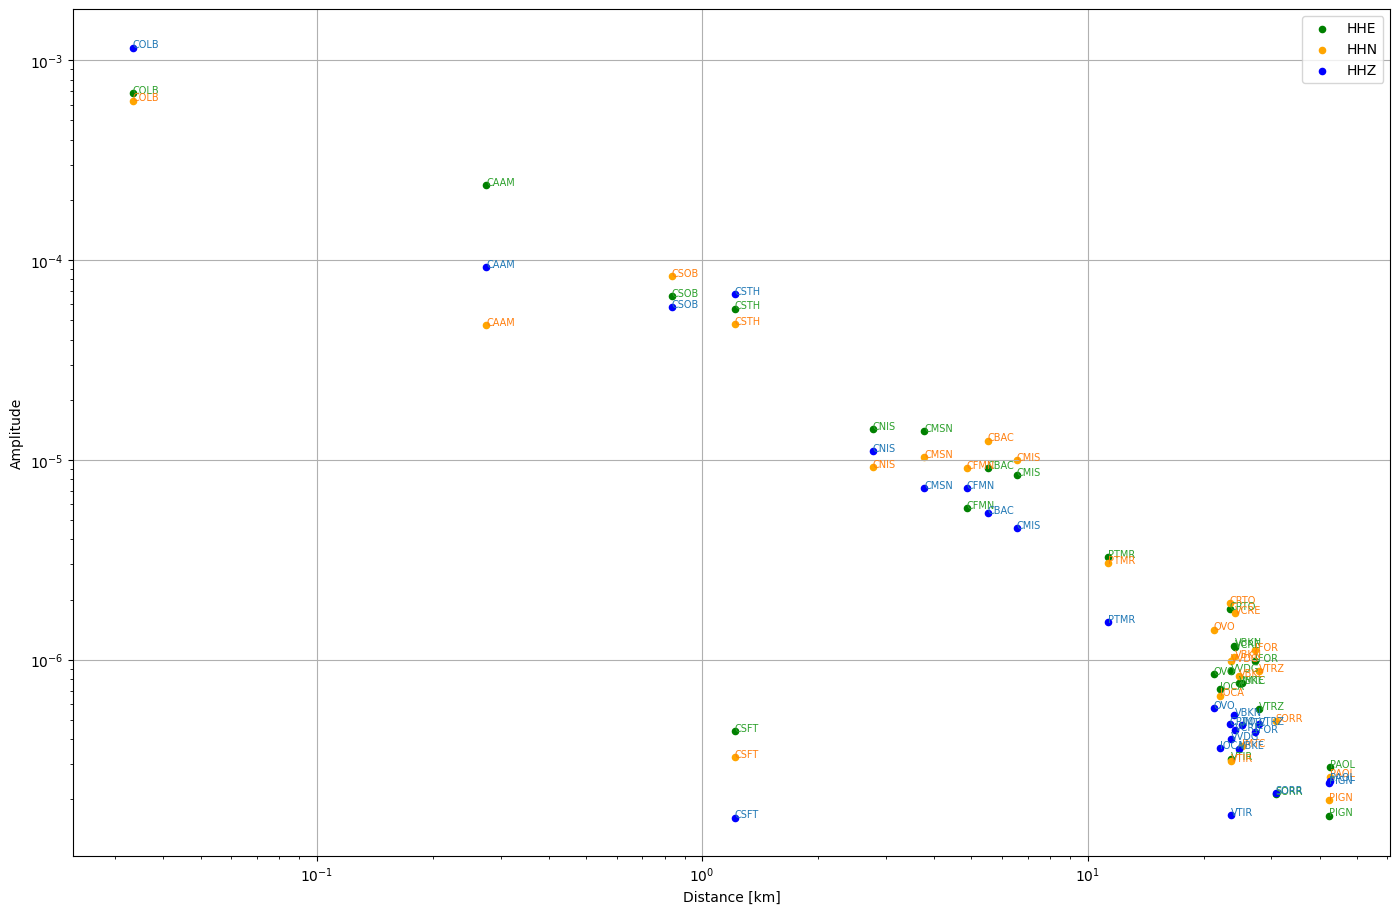

In [360]:
#SAVE FIGURE SWITCH
save_fig=True

# Creazione della figura e dei subplot
fig, axs = plt.subplots(1, 1, figsize=(17, 11), sharex=False)

# Plot per il primo subplot
axs.scatter(num.array(distance1),
                num.array(hhe),
                label='HHE', s=20, color='green')
axs.scatter(num.array(distance2),
                num.array(hhn),
                label='HHN', s=20, color='orange')
axs.scatter(num.array(distance3),
                num.array(hhz),
                label='HHZ', s=20, color='blue')
axs.set_xscale("log")
axs.set_yscale("log")
axs.set_ylabel('Amplitude')
axs.grid(True)
axs.set_xlabel('Distance [km]')
axs.legend()

for i, txt in enumerate(channel1):
    axs.annotate(txt, (distance1[i], hhe[i]),color='tab:green',size=7)

for i, txt in enumerate(channel2):
    axs.annotate(txt, (distance2[i], hhn[i]),color='tab:orange',size=7)

for i, txt in enumerate(channel3):
    axs.annotate(txt, (distance3[i], hhz[i]),color='tab:blue',size=7)

if save_fig:

    figname = os.path.join(plotdir, name + '_amplitude_vs_distance.pdf')
    if os.path.isfile(figname):
        os.remove(figname)

    plt.savefig(figname)

    figname_svg = os.path.join(plotdir, name + '_amplitude_vs_distance.svg')
    if os.path.isfile(figname_svg):
        os.remove(figname_svg)

    plt.savefig(figname_svg)